<a href="https://colab.research.google.com/github/aparnasree2020/CAS_RPM_2023_GBM/blob/main/RPM_Run_Models_compare_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

Here we will install the packages necessary to run this workshop - Part 1
The installation will take about 20 minutes

In [ ]:
print("Welcome")

[1] "Welcome"


In [ ]:
start_time <- Sys.time()
# Comment after installation so that the whole notebook can be run in one go
install.packages('xgboost')
install.packages('ggplot2')
install.packages('plotly')
install.packages('pROC')
install.packages('lightgbm')
install.packages('reshape2')
install.packages("caret")
install.packages("knitr")

end_time <- Sys.time()
elapsed_time <- difftime(end_time, start_time, units = "secs")
print(paste("Installation of libraries took: ", round(elapsed_time/60, 2), " minutes"))

#"Installation of libraries took:  20.71  minutes"




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘later’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘recipes’


Instal

[1] "Installation of libraries took:  26.01  minutes"


# Load Libraries

In [ ]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(ggplot2)
library(plotly)
library(pROC)
library(lightgbm)
library(reshape2 )
library(caret)
library(knitr)

#library(gt)
#library(measures)
#library(gbm)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.3.0     ✔ forcats 1.0.0
✔ readr   2.1.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘plotly’


The following object is masked from ‘package:xgboost’:

    slice


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

   

# Load CSV datafile 
## *  Data split as train and test (80/20 split) and stored in git

*   Train data - Used for model training
*   Test data - Hold out data used for evaluating model performance

In [ ]:
train_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_train_clean.csv"
test_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_test_clean.csv"
train_data <- read.csv(file =train_file, header = TRUE )
test_data <- read.csv(file =test_file, header = TRUE )
x_train <- train_data[, !names(train_data) %in% "claim_count_pd"]
y_train <- train_data$claim_count_pd
x_test <- test_data[, !names(test_data) %in% "claim_count_pd"]
y_test <- test_data$claim_count_pd

# Fit a standard GLM 

In [ ]:
# Fit a GLM
fit <- step(glm(y_train ~ ., data = x_train, family = "gaussian"), direction = "both", trace = FALSE)
pred_y_test <- predict(fit, newdata = x_test, type = "response")
pred_y_test_bin = ifelse(pred_y_test > 0.1, 1, 0)
dataout_GLM <- data.frame(pred_y_test_bin, y_test)

#XGboost with essential hyperparameters 

All features are used for this fit

In [ ]:
print(colnames(x_train))

 [1] "py"                          "late_payments"              
 [3] "credit"                      "veh_count"                  
 [5] "driver_count"                "veh_driver_ratio"           
 [7] "veh_age"                     "limit_pd"                   
 [9] "driver_age"                  "acc_minor"                  
[11] "acc_major"                   "vio_speed"                  
[13] "vio_minor"                   "vio_major"                  
[15] "pol_tenure"                  "ee_pd"                      
[17] "geo_pop_density_ntile"       "geo_median_home_value_ntile"
[19] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
[21] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
[23] "prior_claim_freq_bi"         "prior_claim_freq_pd"        
[25] "prior_claim_freq_med"        "prior_claim_freq_pip"       
[27] "prior_claim_freq_um"         "prior_claim_freq_uim"       
[29] "prior_claim_freq_coll"       "prior_claim_freq_comp"      
[31] "prior_claim_freq_to

Convert data to XGB format

In [ ]:
dtrain <- xgb.DMatrix(data = as.matrix(x_train)
                        , label = y_train
  )
  dtest <- xgb.DMatrix(data = as.matrix(x_test)
                       , label = y_test
  )


## Explanation of Weights

*   The XGboost has a feature "scale_pos_weight" which is a hyperparameter in XGBoost that adjusts the weight of positive samples relative to negative samples in imbalanced datasets. It is defined as the ratio of the number of negative samples to the number of positive samples and is used to help the model learn more from the minority class.

*    This is an important hyper parameter, especially for classification task with unbalanced dataset. 
---

## Explanation of AUC 
* XGboost has aother feature "eval_metric = "auc", AUC stands for Area Under the Curve and is a measure of the performance of a binary classifier. It represents the degree or measure of separability between the true positive rate (TPR) and the false positive rate (FPR). AUC ranges from 0 to 1, where an AUC of 1 indicates perfect classification performance, and an AUC of 0.5 indicates a random classification. AUC is commonly used to compare the performance of different models, and it is considered a more reliable measure than accuracy in imbalanced datasets.

---
## Explanation of eta ( also known as learning rate)  
The learning rate controls the magnitude of the updates to the model weights during training. A smaller learning rate means that the model makes smaller updates to the weights at each iteration, which can result in slower convergence but can also help prevent overfitting. On the other hand, a larger learning rate can lead to faster convergence but may also result in overfitting or instability.
* The learning rate is also multiplied by a shrinkage factor (denoted by the parameter lambda or alpha) to further control the magnitude of the updates. The idea is to have a larger learning rate in the beginning of the optimization. As you get closer to the global minima, the idea is to reduce the learning rate. 

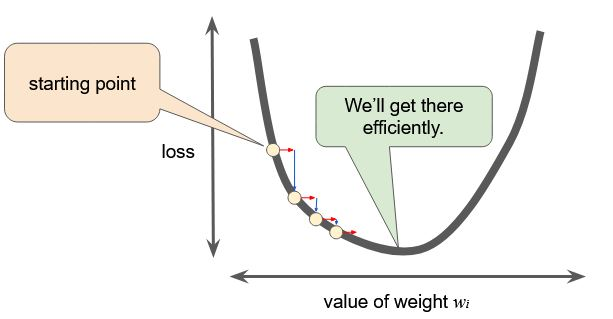

Reference 
https://developers.google.com/machine-learning/crash-course/reducing-loss/learning-rate 

In [ ]:
# Calculate weights based on ratio of classes
pos_weight <- sum(y_train == 0) / sum(y_train == 1)
print(pos_weight)
fit <- xgboost(data = dtrain, nrounds = 100, objective = "binary:logistic", eta = 0.5, max_depth = 9,eval_metric = "auc",scale_pos_weight = pos_weight,silent = 1,verbose = 1)

pred_y_test <- predict(fit, dtest) # Predict the classes for the test data
pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)

pred_y_train <- predict(fit, dtest) # Predict the classes for the test data
pred_y_train_bin = ifelse(pred_y_train > 0.5, 1, 0)


dataout_XGboost_simple <- data.frame(pred_y_test_bin, y_test,pred_y_train_bin,y_train)
roc <- roc(y_test, pred_y_test_bin)
print(roc)

[1] 8.975062
[13:59:08] WARNING: src/learner.cc:767: 
Parameters: { "silent" } are not used.

[1]	train-auc:0.702176 
[2]	train-auc:0.740570 
[3]	train-auc:0.765874 
[4]	train-auc:0.792138 
[5]	train-auc:0.805777 
[6]	train-auc:0.818364 
[7]	train-auc:0.823732 
[8]	train-auc:0.829236 
[9]	train-auc:0.838602 
[10]	train-auc:0.841530 
[11]	train-auc:0.848167 
[12]	train-auc:0.853903 
[13]	train-auc:0.862202 
[14]	train-auc:0.872366 
[15]	train-auc:0.879057 
[16]	train-auc:0.885797 
[17]	train-auc:0.893407 
[18]	train-auc:0.894512 
[19]	train-auc:0.894902 
[20]	train-auc:0.904681 
[21]	train-auc:0.907460 
[22]	train-auc:0.913614 
[23]	train-auc:0.917239 
[24]	train-auc:0.918694 
[25]	train-auc:0.924356 
[26]	train-auc:0.926982 
[27]	train-auc:0.928703 
[28]	train-auc:0.932934 
[29]	train-auc:0.936314 
[30]	train-auc:0.941065 
[31]	train-auc:0.945561 
[32]	train-auc:0.947158 
[33]	train-auc:0.949987 
[34]	train-auc:0.951739 
[35]	train-auc:0.952689 
[36]	train-auc:0.954159 
[37]	train-auc:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = y_test, predictor = pred_y_test_bin)

Data: pred_y_test_bin in 71980 controls (y_test 0) < 8020 cases (y_test 1).
Area under the curve: 0.9755


### Insights 
Since the ROC here is 0.95, we can consider this to be a good model. 
Downstream, we will try to improve this even further by using Cross validation and hyper parameter tuning techniques

## Importance matrix

The importance matrix in XGBoost is a tool that helps to measure the relative importance of each feature in the model. It is calculated based on the contribution of each feature to the reduction of the loss function during training. There are two types of importance matrices in XGBoost: weight-based and gain-based. The importance matrix can be used for feature selection or dimensionality reduction, and it can be visualized using a bar chart or heatmap to make it easier to interpret the results.

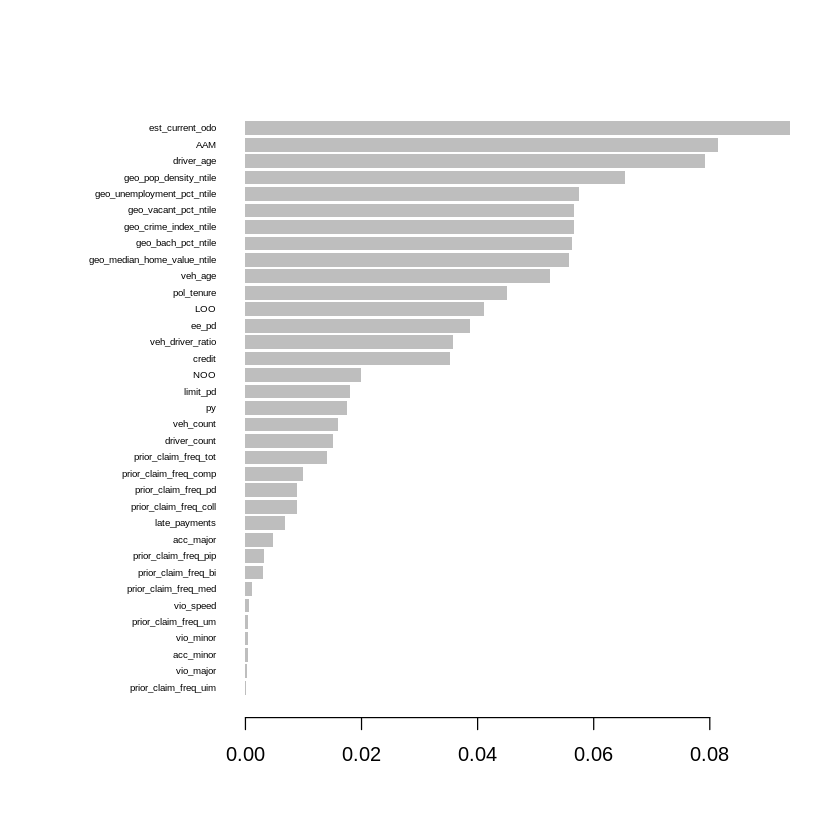

In [ ]:
importance_matrix <- xgb.importance(colnames(dtrain), model = fit)
importance_matrix <- subset(importance_matrix, select = c(Feature,Gain))
  
xgb.plot.importance(importance_matrix) 
top_10_features <- head(importance_matrix$Feature, 10)

In [ ]:
print(top_10_features)

 [1] "est_current_odo"             "AAM"                        
 [3] "driver_age"                  "geo_pop_density_ntile"      
 [5] "geo_unemployment_pct_ntile"  "geo_vacant_pct_ntile"       
 [7] "geo_crime_index_ntile"       "geo_bach_pct_ntile"         
 [9] "geo_median_home_value_ntile" "veh_age"                    


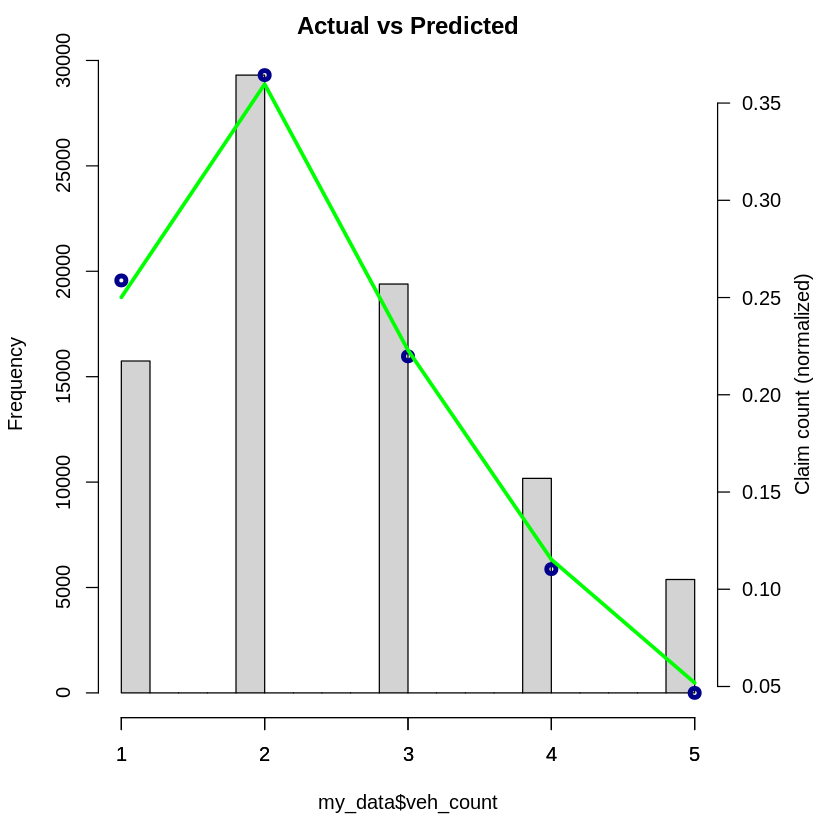

In [ ]:
my_data <- x_train
my_data$y_train <- dataout_XGboost_simple$y_train
my_data$pred_y_train_bin <- dataout_XGboost_simple$pred_y_train_bin

home_plot <- my_data %>%
    mutate(nt = veh_count) %>%
    group_by(nt) %>%
    summarize(  act = sum(y_train)
                , pred = sum(pred_y_train_bin)
                , exposures = sum(veh_count)
    ) %>%
    mutate(   actual = act/sum(act)
              , predicted = pred/sum(pred))

  header = "Actual vs Predicted"
  side4_text = 'Claim count (normalized)'
  lt_text = 'left ' 
  par(mar=c(5, 4, 2, 5) + 0.1)

  #barplot(home_plot$bin_sum,las=2,col="lightblue",ylim = c(0,max(home_plot$exposures)*1.1))
  h<- hist(my_data$veh_count,main = "")
  bin_centers <- (h$breaks[-1] + h$breaks[-length(h$breaks)]) / 2
  par(new=TRUE)
  plot(home_plot$nt, home_plot$predicted, col='darkblue',lwd= 4, axes=FALSE, xlab="", ylab="",main=header)
  axis(4, ylim=c(0,1),col="black",las=1)
  axis(1, xlim=c(0,1),col="black",las=1)
  mtext(side4_text,side=4,line=3.0,col="black",font=7)
  mtext(header,side=3,line=3.0,col="black",font=7)
  #mtext(lt_text, side = 2, line=3.0,col="black",font=7)
  #box()
  #mtext(var,side=1,col="black",line=2.5,font=7) 
  lines(home_plot$nt,home_plot$actual, col="green",lwd=3) 

### Improving GLM using XGboost insights 

In this secion, we will try to improve the GLM output based on results from Xgboost. 


1. Reduce number of features based on XGboost ( feature selection) 
2. Use appropriate weight function and evaluation metric ( AUC) 




In [ ]:
x_train_top10 <- x_train[, c(top_10_features)]
x_test_top10 <- x_test[, c(top_10_features)]
#print(x_train)



In [ ]:
head(x_test_top10)

,est_current_odo,AAM,driver_age,geo_pop_density_ntile,geo_unemployment_pct_ntile,geo_vacant_pct_ntile,geo_crime_index_ntile,geo_bach_pct_ntile,geo_median_home_value_ntile,veh_age
,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,73732.0,2631.00,81,71,73,57,48,48,21,14
2,116354.1,12954.84,56,21,68,74,75,13,26,19
3,68800.0,12107.00,58,29,21,68,48,35,28,6
4,79115.0,12954.84,46,70,69,22,8,76,50,3
5,108335.0,12954.84,74,53,87,67,75,13,16,7
6,111340.5,12651.09,63,19,41,77,78,7,10,4


In [ ]:
# Fit a GLM
weight_vector <- ifelse(y_train == 1, 10, 1)
fit <- glm(y_train ~ ., data = x_train_top10, family = "binomial",weights = weight_vector)
pred_y_test <- predict(fit, newdata = x_test_top10, type = "response")
pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
dataout_GLM_top10 <- data.frame(pred_y_test_bin, y_test)
conf_mat <- table(y_test, pred_y_test_bin)
print(conf_mat)


      pred_y_test_bin
y_test     0     1
     0 31748 40232
     1  2530  5490


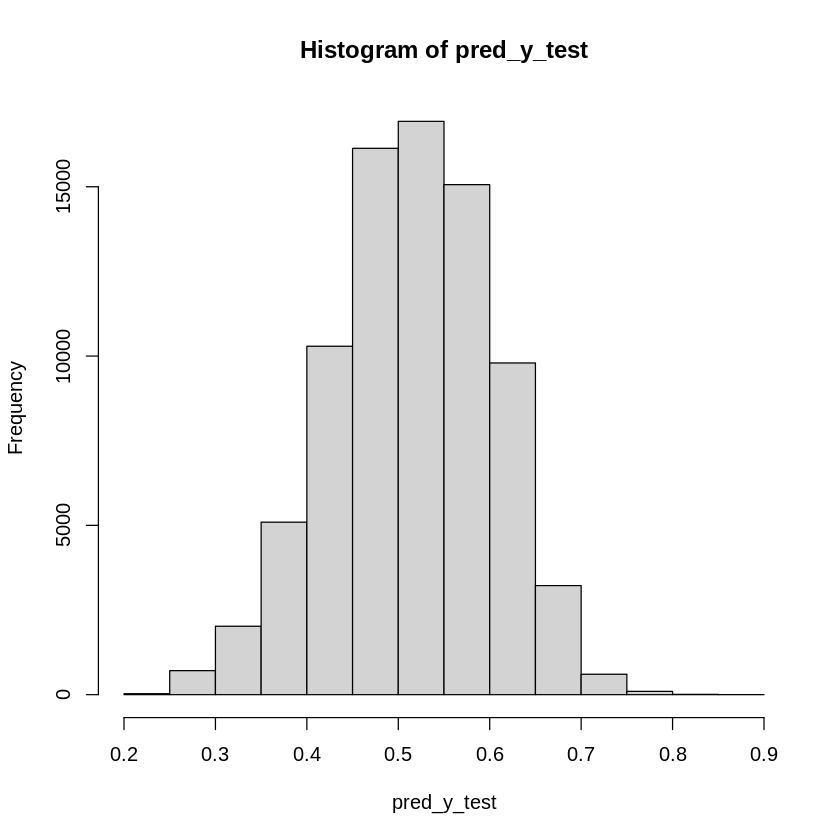

In [ ]:
hist(pred_y_test)

## Improve XGboost with hyperparameters selected from 

In [ ]:
pos_weight <- sum(y_train == 0) / sum(y_train == 1)
print(pos_weight)
fit <- xgboost(data = dtrain, nrounds = 100, objective = "binary:logistic", eta = 0.5, max_depth = 9,eval_metric = "auc",scale_pos_weight = pos_weight,silent = 1,verbose = 1)

pred_y_test <- predict(fit, dtest) # Predict the classes for the test data
pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)

pred_y_train <- predict(fit, dtest) # Predict the classes for the test data
pred_y_train_bin = ifelse(pred_y_train > 0.5, 1, 0)


dataout_XGboost_simple <- data.frame(pred_y_test_bin, y_test,pred_y_train_bin,y_train)
roc <- roc(y_test, pred_y_test_bin)
print(roc)

#Calculate the metric for each model

In [ ]:
library(pROC)

# Define a function to compute the metrics for one model
compute_model_metrics <- function(pred, true, var_name) {
  tn <- sum((pred == 0) & (true == 0))
  fp <- sum((pred == 1) & (true == 0))
  fn <- sum((pred == 0) & (true == 1))
  tp <- sum((pred == 1) & (true == 1))
  total <- length(pred)
  
  accuracy <- (tp + tn) / total
  precision <- tp / (tp + fp)
  sensitivity <- tp / (tp + fn)
  f1_score <- 2 * precision * sensitivity / (precision + sensitivity)
  
  roc <- roc(true, pred)
  auc <- auc(roc)
  gini <- (auc * 2) - 1
  
  # Create a data frame to store the metrics
  metrics_df <- data.frame(var_name = var_name,
                           accuracy = accuracy,
                           precision = precision,
                           sensitivity = sensitivity,
                           f1_score = f1_score,
                           roc_auc = auc,
                           gini = gini,
                           TP = tp,
                           FP = fp,
                           TN = tn,
                           FN = fn,
                           Samples = total)
  
  # Return the data frame
  return(metrics_df)
}
# Compute the metrics for each model and combine the resulting data frames
metrics_df <- rbind(compute_model_metrics(dataout_XGboost_simple$pred_y_test_bin, dataout_XGboost_simple$y_test, "XGBoost"),
                    compute_model_metrics(dataout_GLM_top10$pred_y_test_bin, dataout_GLM_top10$y_test, "GLM Top 10"),
                    compute_model_metrics(dataout_GLM$pred_y_test_bin, dataout_GLM$y_test, "GLM"))
#print(metrics_df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



# Pretty print table of metrics

In [ ]:
knitr::kable(metrics_df,digits = 2)



|var_name   | accuracy| precision| sensitivity| f1_score|   roc_auc| gini|   TP|    FP|    TN|   FN| Samples|
|:----------|--------:|---------:|-----------:|--------:|---------:|----:|----:|-----:|-----:|----:|-------:|
|XGBoost    |     0.96|      0.74|        0.99|     0.85| 0.9754666| 0.95| 7933|  2751| 69229|   87|   80000|
|GLM Top 10 |     0.47|      0.12|        0.68|     0.20| 0.5628028| 0.13| 5490| 40232| 31748| 2530|   80000|
|GLM        |     0.54|      0.14|        0.67|     0.23| 0.5988378| 0.20| 5386| 34111| 37869| 2634|   80000|

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



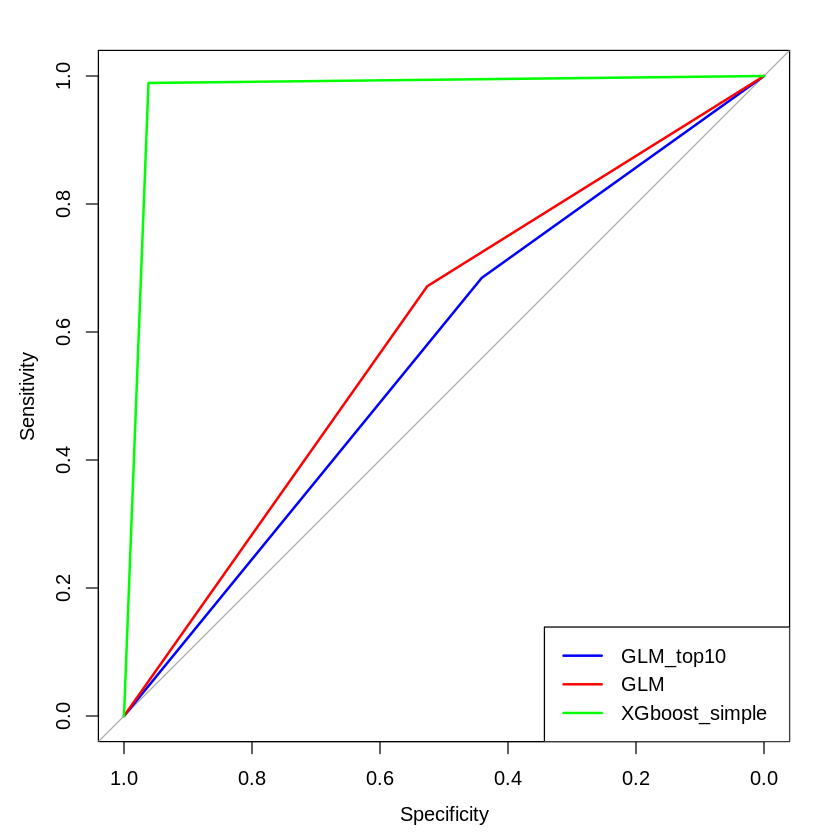

In [ ]:
# Create a ROC curve
roc_curve1 <- roc(dataout_GLM_top10$y_test, dataout_GLM_top10$pred_y_test_bin)
roc_curve2 <- roc(dataout_GLM$y_test, dataout_GLM$pred_y_test_bin)
roc_curve3 <- roc(dataout_XGboost_simple$y_test, dataout_XGboost_simple$pred_y_test_bin)

# Plot the first ROC curve in blue
plot(roc_curve1, col = "blue")

# Add the second ROC curve in red
lines(roc_curve2, col = "red")
lines(roc_curve3, col = "green")
# Add a legend
legend("bottomright", legend = c("GLM_top10", "GLM","XGboost_simple"),
       col = c("blue", "red","green"), lwd = 2)

#Plot the various metrics as plots

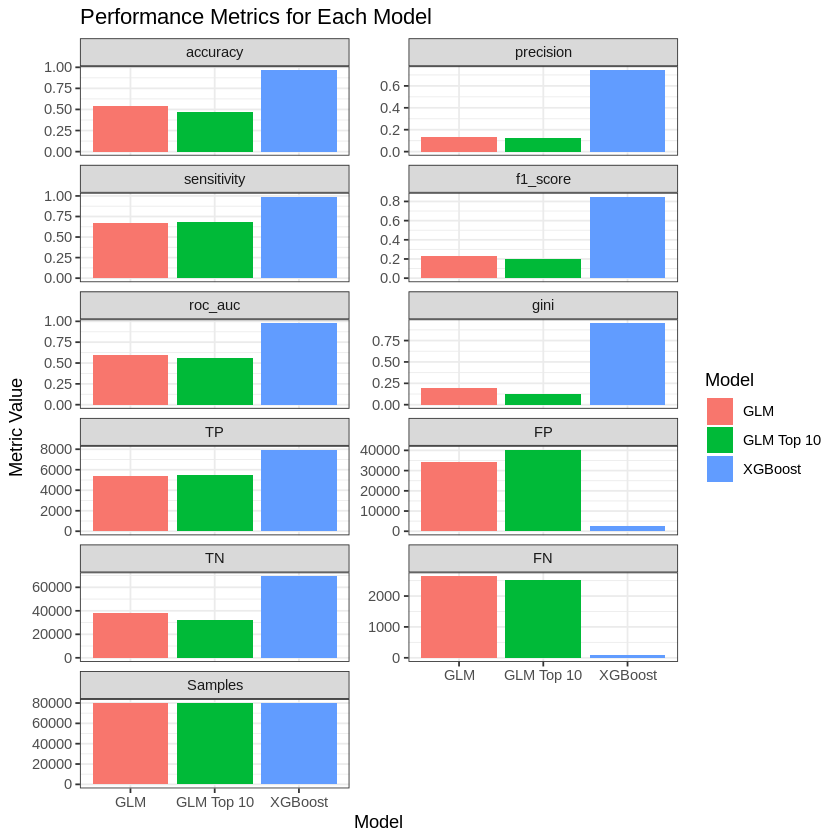

In [ ]:
options(warn=-1)
# Melt the data frame to a long format for plotting
metrics_df_melt <- melt(metrics_df, id.vars = "var_name", variable.name = "metric")

# Plot each performance metric for each model using ggplot2 and facet_wrap()
ggplot(metrics_df_melt, aes(x = var_name, y = value, fill = var_name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "Metric Value", fill = "Model") +
  ggtitle("Performance Metrics for Each Model") +
  facet_wrap(~metric, scales = "free_y", nrow = 10) +
  theme_bw() +
  theme(plot.background = element_rect(fill = "white", size = 4),
        panel.background = element_rect(fill = "white", size = 4))

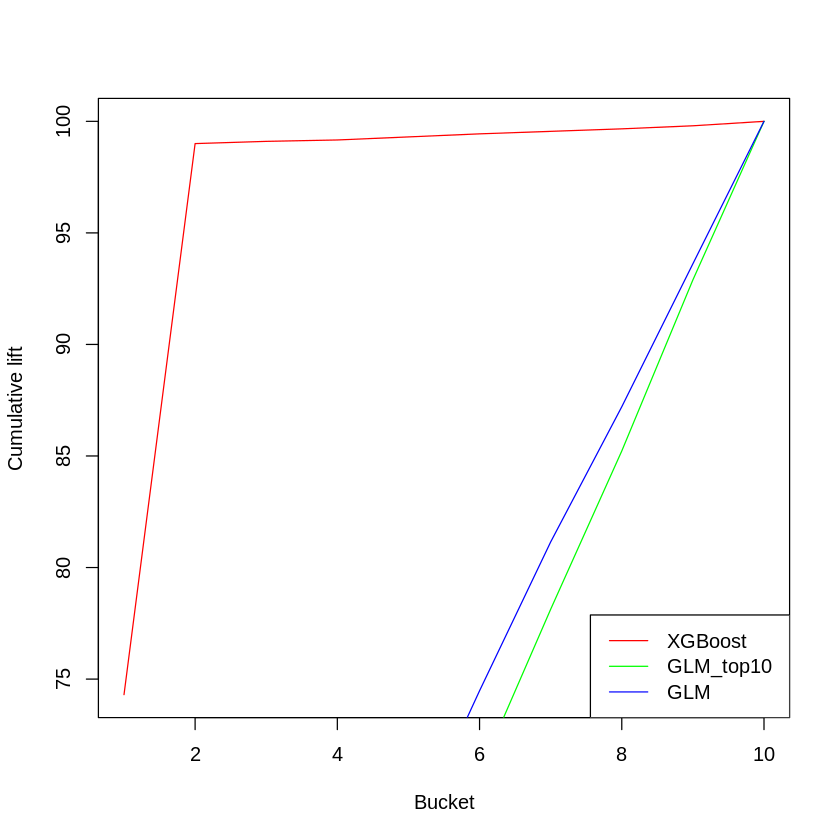

In [ ]:
library(dplyr)
options(warn=-1)
# Define the lift function
lift <- function(depvar, predcol, groups=10) {
  if(!require(dplyr)) {
    install.packages("dplyr")
    library(dplyr)
  }
  if(is.factor(depvar)) depvar <- as.integer(as.character(depvar))
  if(is.factor(predcol)) predcol <- as.integer(as.character(predcol))
  helper = data.frame(cbind(depvar, predcol))
  helper[,"bucket"] = ntile(-helper[,"predcol"], groups)
  gaintable = helper %>% group_by(bucket)  %>%
    summarise_at(vars(depvar), funs(total = n(),
                                    totalresp=sum(., na.rm = TRUE))) %>%
    mutate(Cumresp = cumsum(totalresp),
           Gain=Cumresp/sum(totalresp)*100,
           Cumlift=Gain/(bucket*(100/groups)))
  return(gaintable)
}

# Example usage
dt1 <- lift(dataout_XGboost_simple$y_test, dataout_XGboost_simple$pred_y_test_bin, groups = 10)
dt2 <- lift(dataout_GLM_top10$y_test, dataout_GLM_top10$pred_y_test_bin, groups = 10)
dt3 <- lift(dataout_GLM$y_test, dataout_GLM$pred_y_test_bin, groups = 10)

# Plot the lift charts with different colors
graphics::plot(dt1$bucket, dt1$Gain, type="l", ylab="Cumulative lift", xlab="Bucket", col="red",linetype = "dashed")
lines(dt2$bucket, dt2$Gain, col="green")
lines(dt3$bucket, dt3$Gain, col="blue",linetype = "dashed")
legend("bottomright", legend=c("XGBoost", "GLM_top10", "GLM"), col=c("red", "green", "blue"), lty=1)

# END

#Todo

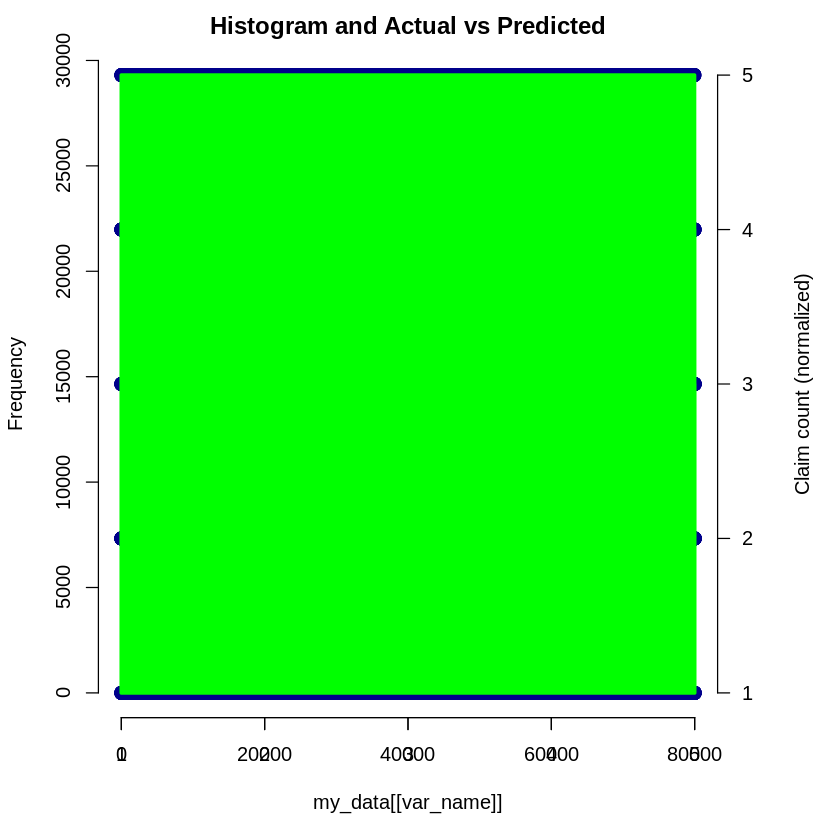

In [ ]:
plot_actual_predicted <- function(my_data, var_name) {


  out_data <- my_data %>%
    group_by(!!sym(var_name)) %>%
    summarize(act = sum(y_train),
              pred = sum(pred_y_train_bin),
              exposures = sum(!!sym(var_name))) %>%
    mutate(actual = act/sum(act),
           predicted = pred/sum(pred))

  header = "Histogram and Actual vs Predicted"
  side4_text = 'Claim count (normalized)'
  lt_text = 'left ' 
  par(mar=c(5, 4, 2, 5) + 0.1)

  # Plot the histogram of the specified variable
  h <- hist(my_data[[var_name]], main = "")

  # Plot the actual and predicted values
  bin_centers <- (h$breaks[-1] + h$breaks[-length(h$breaks)]) / 2
  par(new = TRUE)
  plot(my_data[[var_name]], my_data$predicted, col = 'darkblue', lwd = 4, axes = FALSE, xlab = "", ylab = "", main = header)
  axis(4, ylim = c(0, 1), col = "black", las = 1)
  axis(1, xlim = c(0, 1), col = "black", las = 1)
  mtext(side4_text, side = 4, line = 3.0, col = "black", font = 7)
  mtext(header, side = 3, line = 3.0, col = "black", font = 7)
  lines(my_data[[var_name]], my_data$actual, col = "green", lwd = 3)

}

my_data$pred_y_train_bin <- dataout_XGboost_simple$pred_y_train_bin

plot_actual_predicted(my_data, "veh_count")

In [ ]:
start_time <- Sys.time()

#train_idx <- createDataPartition(train_data, p = 0.5, list = FALSE)
train_data_grid <- train_data %>% sample_frac(0.3, replace = FALSE)
x_train_grid <- train_data_grid[, !names(train_data_grid) %in% "claim_count_pd"]
y_train_grid <- train_data_grid$claim_count_pd

dtrain <- xgb.DMatrix(data = as.matrix(x_train_grid)
                        , label = y_train_grid
  )
pos_weight <- sum(y_train == 0) / sum(y_train == 1)

# Define the hyperparameter search space
nrounds <- c(100,150)
max_depth <- c(8,10,12,14)
eta <- c(0.3, 0.5)
gamma <- c( 0.1, 0.5)

# Perform random search for hyperparameter tuning
set.seed(123)
xgb_cv <- xgb.cv(
  data = dtrain,
  nfold = 2,
  nrounds = sample(nrounds, 1),
  max_depth = sample(max_depth, 1),
  eta = sample(eta, 1),
  gamma = sample(gamma, 1),
  objective = "binary:logistic",
  eval_metric = "auc",
  scale_pos_weight = pos_weight
)

# Get the best performing hyperparameters
best_params <- xgb_cv$best_iteration
end_time <- Sys.time()
elapsed_time <- difftime(end_time, start_time, units = "secs")
print(paste("XGboost Tuning took: ", round(elapsed_time/60, 2), " minutes"))

[1]	train-auc:0.887290+0.008934	test-auc:0.566571+0.004622 
[2]	train-auc:0.947843+0.014696	test-auc:0.565502+0.002814 
[3]	train-auc:0.969836+0.012298	test-auc:0.572623+0.001404 
[4]	train-auc:0.978062+0.010197	test-auc:0.576312+0.001941 
[5]	train-auc:0.983456+0.008926	test-auc:0.582415+0.005140 
[6]	train-auc:0.987043+0.006372	test-auc:0.585807+0.000961 
[7]	train-auc:0.992728+0.003575	test-auc:0.583411+0.003615 
[8]	train-auc:0.994024+0.002972	test-auc:0.585579+0.003723 
[9]	train-auc:0.994850+0.002877	test-auc:0.586475+0.002564 
[10]	train-auc:0.995995+0.002467	test-auc:0.584758+0.003215 
[11]	train-auc:0.997334+0.001495	test-auc:0.584104+0.004107 
[12]	train-auc:0.998211+0.000995	test-auc:0.584650+0.005589 
[13]	train-auc:0.998324+0.001000	test-auc:0.584284+0.005087 
[14]	train-auc:0.999068+0.000505	test-auc:0.583513+0.005384 
[15]	train-auc:0.999483+0.000175	test-auc:0.581023+0.007224 
[16]	train-auc:0.999650+0.000145	test-auc:0.581872+0.006140 
[17]	train-auc:0.999727+0.000167	


## XGboost with Caret cross validation

* 
* 

## Lightgbm 


Plotting


In [ ]:
summary(my_data)

       py       late_payments        credit         veh_count    
 Min.   :2015   Min.   :0.0000   Min.   : 1.000   Min.   :1.000  
 1st Qu.:2016   1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.:2.000  
 Median :2016   Median :0.0000   Median : 5.000   Median :2.000  
 Mean   :2016   Mean   :0.1449   Mean   : 5.059   Mean   :2.502  
 3rd Qu.:2017   3rd Qu.:0.0000   3rd Qu.: 7.000   3rd Qu.:3.000  
 Max.   :2018   Max.   :5.0000   Max.   :10.000   Max.   :5.000  
  driver_count   veh_driver_ratio    veh_age         limit_pd     
 Min.   :1.000   Min.   :0.500    Min.   : 0.00   Min.   : 25000  
 1st Qu.:2.000   1st Qu.:1.000    1st Qu.: 4.00   1st Qu.: 50000  
 Median :2.000   Median :1.000    Median :10.00   Median :100000  
 Mean   :2.167   Mean   :1.215    Mean   :10.03   Mean   : 95939  
 3rd Qu.:3.000   3rd Qu.:1.500    3rd Qu.:14.00   3rd Qu.:100000  
 Max.   :5.000   Max.   :2.500    Max.   :37.00   Max.   :500000  
   driver_age      acc_minor         acc_major         vio_speed     

In [ ]:
library(tidyverse)

# Create a dataframe
df <- data.frame(x = rnorm(50), y = rnorm(50), z = factor(sample(letters[1:3], 50, replace = TRUE)))

# Create a summary of the variables in the dataframe
summary_df <- summary(df)

# Convert the summary to a dataframe
summary_df <- as.data.frame(summary_df)

# Add a column for the variable names
summary_df$variable <- rownames(summary_df)

# Reorder the columns
summary_df <- summary_df[, c(4, 1:3)]

# Print the summary dataframe
print(summary_df)

   variable Var1    Var2               Freq
1         1            x Min.   :-1.74049  
2         2            x 1st Qu.:-0.76109  
3         3            x Median : 0.05511  
4         4            x Mean   : 0.11488  
5         5            x 3rd Qu.: 0.87372  
6         6            x Max.   : 2.59480  
7         7            y Min.   :-1.92307  
8         8            y 1st Qu.:-1.08816  
9         9            y Median :-0.08489  
10       10            y Mean   :-0.25058  
11       11            y 3rd Qu.: 0.28994  
12       12            y Max.   : 2.03116  
13       13            z             a:20  
14       14            z             b:14  
15       15            z             c:16  
16       16            z               <NA>
17       17            z               <NA>
18       18            z               <NA>


In [ ]:
start_time <- Sys.time()
# Define the LightGBM dataset object for the training data
train_data_lgb <- lgb.Dataset(data = as.matrix(x_train), label = y_train)

# Define the LightGBM dataset object for the test data
test_data_lgb <- lgb.Dataset(data = as.matrix(x_test), label = y_test)

# Define the custom LightGBM model
lgb_train <- function(x, y, wts, param) {
  dtrain <- lgb.Dataset(data = x,
                        label = y,
                        weight = wts,
                        free_raw_data = FALSE)
  lgb.train(params = param,
            data = dtrain,
            verbose = -1)
}

lgb_predict <- function(model, newdata) {
  pred <- predict(model, newdata, num_iteration = model$best_iteration)
  return(as.matrix(pred))
}

# Define the hyperparameters for the LightGBM model
params <- list(objective = "binary",
               metric = "auc",
               boosting_type = "gbdt",
               num_leaves = 31,
               max_depth = -1,
               learning_rate = 0.1,
               feature_fraction = 1,
               bagging_fraction = 1,
               bagging_freq = 0,
               verbose = 1)

# Define the tuning grid for the LightGBM model
grid <- expand.grid(num_leaves = c(100, 200, 300),
                    learning_rate = c(0.01, 0.1, 0.2),
                    bagging_fraction = c(0.5, 0.8, 1))
# Define the search control for automatic machine learning
ctrl <- trainControl(method = "cv",
                     number = 2,
                     verboseIter = TRUE,
                     search = "random",
                     classProbs = TRUE,
                     savePredictions = TRUE)
                     
# Train and tune the LightGBM model using cross-validation and the specified grid
fitLGB <- train(x = x_train,
             y = y_train,
             method = "custom",
             trControl = ctrl,
             tuneGrid = grid,
             metric = "AUC",
             tuneLength = 10,
             lgb_train = lgb_train,
             lgb_predict = lgb_predict,
             verbose = TRUE)

# Print the best hyperparameters found by the tuning process
print(fitLGB$bestTune)

# Predict the probabilities of the positive class for the test data using the best model
pred_y_test_prob <- predict(fitLGB$finalModel, newdata = as.matrix(x_test))
pred_y_test_bin = ifelse(pred_y_test_prob > 0.5, 1, 0)

# Calculate the AUC score for the test predictions
auc_score <- roc(y_test, pred_y_test_bin)$auc

end_time <- Sys.time()
elapsed_time <- difftime(end_time, start_time, units = "secs")
print(paste("LightGBM took: ", round(elapsed_time/60, 2), " minutes"))

ERROR: ignored

In [ ]:
dataout_XGboost_simple$y_test
dataout_XGboost_simple$pred_y_test_bin

In [ ]:
# I am having trouble in this part, Plotting 
my_data <- x_train
my_data$y_train <- y_train
my_data$pred_y_train_bin <- pred_y_train_bin

plot_y_z_on_right_axis <- function(my_data, x, y, z) {
# Plot y and z on right axis, with histogram of x
# Define y and z limits
y_lim <- c(min(my_data$y, na.rm = TRUE), max(my_data$y, na.rm = TRUE))
z_lim <- c(min(my_data$z, na.rm = TRUE), max(my_data$z, na.rm = TRUE))

ggplot(my_data, aes(x = x)) +
  geom_histogram(alpha = 0.5, fill = "grey", binwidth = 0.1, stat = "count") +
  geom_line(aes(y = y), color = "blue") +
  geom_point(aes(y = z), color = "red") +
  ggtitle("Y and Z Values by X") +
  xlab("X") +
  ylab("X Histogram") +
  scale_y_discrete(name = "Y and Z",
                   limits = c(y_lim[1], y_lim[2], z_lim[1], z_lim[2]),
                   labels = c("Y_min" = y_lim[1], "Y_max" = y_lim[2],
                              "Z_min" = z_lim[1], "Z_max" = z_lim[2])) + 
  theme(axis.title.y.right = element_text(color = "blue"),
        axis.text.y.right = element_text(color = "blue"),
        axis.title.y.left = element_text(color = "grey20"))

}

plot_y_z_on_right_axis(my_data, 'veh_count', 'y_train', 'pred_y_test_bin') 

# End

Unused code below

In [ ]:
#library(Hmisc)
#hist.data.frame(gbm_data$claim_count_pd)

In [ ]:
#library(flextable)
# Convert the data frame to a flextable object
ft_metrics <- flextable(metrics_df)
ft_metrics <- set_formatter(ft_metrics, type = "numeric", digits = 2) # Set the number of decimal places for numeric columns

ft_metrics <- set_header_labels(ft_metrics, var_name = "Model", Samples = "Total Samples")
ft_metrics <- autofit(ft_metrics)
ft_metrics <- add_header_row(ft_metrics, values = "Performance Metrics", merge = 11)
print(ft_metrics)

In [ ]:
# Convert the data frame to a gt object
gt_metrics <- gt(metrics_df)
cols_to_format <- c("accuracy", "precision", "sensitivity", "f1_score", "roc_auc", "gini")
gt_metrics <- data_color(gt_metrics, columns = cols_to_format, color = "white", apply_to = "text")
gt_metrics <- tab_style(gt_metrics, locations = cells_body(cols = cols_to_format), style = list(cell_text(weight = "bold", color = "black"), cell_fill(background.color = "gray")))
gt_metrics <- gt_metrics %>% tab_header(title = "Performance Metrics", subtitle = "for Each Model")

# Display the gt table
gt_metrics

In [ ]:
install.packages('h2o')
library(h2o) # For AutoML
h2o.init()

In [ ]:
#install only the bare minimum libraries
#install.packages('gbm')
#install.packages('shapper')